# Body Segmentation

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

In video production, for example, in weather forecasts, we often need to cut out a human image from camera and place it on top of some other footage. This is typically done using **chroma key** techniques, when a human is filmed in front of a uniform color background, which is then removed. In this lab, we will train a neural network model to cut out the human silhouette.

We will be using [Segmentation Full Body MADS Dataset](https://www.kaggle.com/datasets/tapakah68/segmentation-full-body-mads-dataset) from Kaggle. Download the dataset manually from Kaggle and unzip in into current directory.

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
from skimage.io import imread
from skimage.transform import resize
import os
torch.manual_seed(42)
np.random.seed(42)

AttributeError: partially initialized module 'torchvision' has no attribute 'extension' (most likely due to a circular import)

In [2]:
dataset_path = 'segmentation_full_body_mads_dataset_1192_img/segmentation_full_body_mads_dataset_1192_img'

import os
import matplotlib.pyplot as plt

Let's see how images in the dataset look like:

In [3]:
img_path = os.path.join(dataset_path,'images')
mask_path = os.path.join(dataset_path,'masks')

fnames = os.listdir(img_path)

def load_image(img_name):
    img = plt.imread(os.path.join(img_path,img_name))
    mask = plt.imread(os.path.join(mask_path,img_name))
    return img,mask

(-0.5, 511.5, 383.5, -0.5)

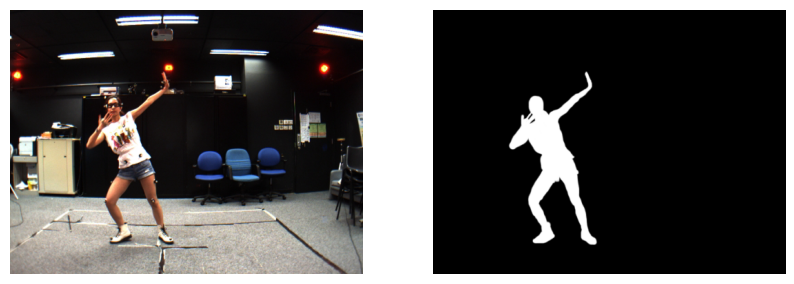

In [4]:
img, mask = load_image(fnames[5])

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img)
ax[1].imshow(mask)
ax[0].axis('off')
ax[1].axis('off')

# Kaleb's Implementation

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_size = 0.9
lr = 1e-3
weight_decay = 1e-6
batch_size = 32
epochs = 30

## Prep the data

In [6]:
# Load all images
images, masks = [],[]
for i in fnames: 
    X, y = load_image(i)
    images.append(X), masks.append(y)

In [7]:
# Prep them
size = (256, 256)
images = torch.permute(torch.FloatTensor(np.array([resize(image, size, mode='constant', anti_aliasing=True,) for image in images])), (0, 3, 1, 2))
# masks = torch.FloatTensor(np.array([resize(mask, size, mode='constant', anti_aliasing=False) > 0.5 for mask in masks])).unsqueeze(1)
masks_resized = []
for mask in masks:
    # If masks are RGB, convert to grayscale by taking one channel or averaging channels
    if mask.shape[-1] == 4:  # RGBA
            mask = mask[:, :, :3]  # Remove alpha channel
    if mask.ndim == 3 and mask.shape[-1] == 3: # RGB
        mask = mask[:, :, 0]  # or np.mean(mask, axis=-1) for averaging channels
    resized_mask = resize(mask, size, mode='constant', anti_aliasing=False) > 0.5
    masks_resized.append(resized_mask)
masks = torch.FloatTensor(np.array(masks_resized)).unsqueeze(1)

indices = np.random.permutation(range(len(images)))
train_size = int(train_size * len(images))
train_ind = indices[:train_size]
test_ind = indices[train_size:]

train_dataset = (images[train_ind, :, :, :], masks[train_ind, :, :, :])
test_dataset = (images[test_ind, :, :, :], masks[test_ind, :, :, :])

Train dataset shape: [1072, 1072]
Test dataset shape: [120, 120]
Example train dataset


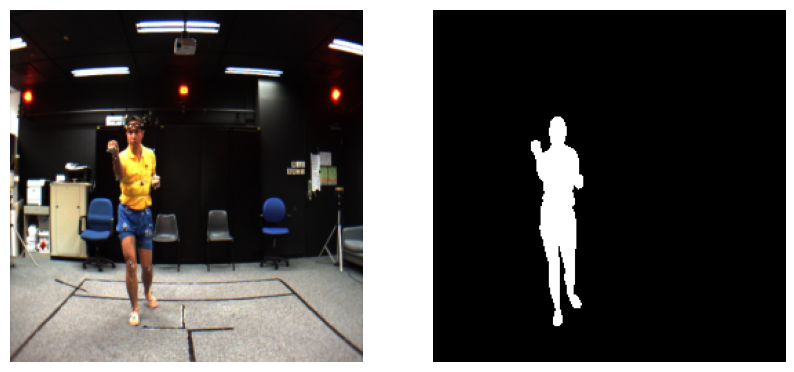

In [8]:
print(f"Train dataset shape: {[len(a) for a in train_dataset]}")
print(f"Test dataset shape: {[len(a) for a in test_dataset]}")
print(f"Example train dataset")
img = train_dataset[0][0]
mask = train_dataset[1][0]

# Convert the tensors to numpy arrays and move channels to the last dimension
img = img.permute(1, 2, 0).numpy()
mask = mask.squeeze().numpy()

# Plot the image and the mask
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[1].imshow(mask, cmap='gray')
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [9]:
train_dataloader = torch.utils.data.DataLoader(list(zip(train_dataset[0], train_dataset[1])), batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(list(zip(test_dataset[0], test_dataset[1])), batch_size=1, shuffle=False)
dataloaders = (train_dataloader, test_dataloader)

## Train and Plot Function

In [10]:
def train(dataloaders, model, loss_fn, optimizer, epochs, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            preds = model(imgs)
            loss = loss_fn(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                imgs = imgs.to(device)
                labels = labels.to(device)

                preds = model(imgs)
                loss = loss_fn(preds, labels)

                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)

        tqdm_dct = {'train loss:': train_loss, 'test loss:': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [11]:
def plotn(n, data, only_mask=False):
    images, masks = data[0], data[1]
    fig, ax = plt.subplots(1, n)
    fig1, ax1 = plt.subplots(1, n)
    for i, (img, mask) in enumerate(zip(images, masks)):
        if i == n:
            break
        if not only_mask:
            ax[i].imshow(torch.permute(img, (1, 2, 0)))
        else:
            ax[i].imshow(img[0])
        ax1[i].imshow(mask[0])
        ax[i].axis('off')
        ax1[i].axis('off')
    plt.show()

## Models Used

In [12]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=1)
        self.act0 = nn.ReLU()
        self.bn0 = nn.BatchNorm2d(16)
        self.pool0 = nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1)
        self.act1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 =  nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 =  nn.MaxPool2d(kernel_size=(2,2))

        self.bottleneck_conv = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding=1)
        
        self.upsample0 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv0 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3,3), padding=1)
        self.dec_act0 = nn.ReLU()
        self.dec_bn0 = nn.BatchNorm2d(128)

        self.upsample1 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv1 =  nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3), padding=1)
        self.dec_act1 = nn.ReLU()
        self.dec_bn1 = nn.BatchNorm2d(64)

        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor=2)
        
        self.dec_conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3), padding=1)
        self.dec_act2 = nn.ReLU()
        self.dec_bn2 = nn.BatchNorm2d(32)

        self.upsample3 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(1,1))

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        e0 = self.pool0(self.bn0(self.act0(self.enc_conv0(x))))
        e1 = self.pool1(self.bn1(self.act1(self.enc_conv1(e0))))
        e2 = self.pool2(self.bn2(self.act2(self.enc_conv2(e1))))
        e3 = self.pool3(self.bn3(self.act3(self.enc_conv3(e2))))

        b = self.bottleneck_conv(e3)

        d0 = self.dec_bn0(self.dec_act0(self.dec_conv0(self.upsample0(b))))
        d1 = self.dec_bn1(self.dec_act1(self.dec_conv1(self.upsample1(d0))))
        d2 = self.dec_bn2(self.dec_act2(self.dec_conv2(self.upsample2(d1))))
        d3 = self.sigmoid(self.dec_conv3(self.upsample3(d2)))
        return d3

In [13]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=1)
        self.act0 = nn.ReLU()
        self.bn0 = nn.BatchNorm2d(16)
        self.pool0 = nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1)
        self.act1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.act2 = nn.ReLU()
        
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 =  nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 =  nn.MaxPool2d(kernel_size=(2,2))

        self.bottleneck_conv = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding=1)
        
        self.upsample0 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv0 = nn.Conv2d(in_channels=384, out_channels=128, kernel_size=(3,3), padding=1)
        self.dec_act0 = nn.ReLU()
        self.dec_bn0 = nn.BatchNorm2d(128)

        self.upsample1 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv1 =  nn.Conv2d(in_channels=192, out_channels=64, kernel_size=(3,3), padding=1)
        self.dec_act1 = nn.ReLU()
        self.dec_bn1 = nn.BatchNorm2d(64)

        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv2 = nn.Conv2d(in_channels=96, out_channels=32, kernel_size=(3,3), padding=1)
        self.dec_act2 = nn.ReLU()
        self.dec_bn2 = nn.BatchNorm2d(32)

        self.upsample3 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv3 = nn.Conv2d(in_channels=48, out_channels=1, kernel_size=(1,1))

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        e0 = self.pool0(self.bn0(self.act0(self.enc_conv0(x))))
        e1 = self.pool1(self.bn1(self.act1(self.enc_conv1(e0))))
        e2 = self.pool2(self.bn2(self.act2(self.enc_conv2(e1))))
        e3 = self.pool3(self.bn3(self.act3(self.enc_conv3(e2))))

        cat0 = self.bn0(self.act0(self.enc_conv0(x)))
        cat1 = self.bn1(self.act1(self.enc_conv1(e0)))
        cat2 = self.bn2(self.act2(self.enc_conv2(e1)))
        cat3 = self.bn3(self.act3(self.enc_conv3(e2)))

        b = self.bottleneck_conv(e3)

        d0 = self.dec_bn0(self.dec_act0(self.dec_conv0(torch.cat((self.upsample0(b), cat3), dim=1))))
        d1 = self.dec_bn1(self.dec_act1(self.dec_conv1(torch.cat((self.upsample1(d0), cat2), dim=1))))
        d2 = self.dec_bn2(self.dec_act2(self.dec_conv2(torch.cat((self.upsample2(d1), cat1), dim=1))))
        d3 = self.sigmoid(self.dec_conv3(torch.cat((self.upsample3(d2), cat0), dim=1)))
        return d3

In [14]:
# Beefed version of SegNet 
class KalebNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=1)
        self.act0 = nn.ReLU()
        self.bn0 = nn.BatchNorm2d(16)
        self.pool0 = nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1)
        self.act1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 =  nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 =  nn.MaxPool2d(kernel_size=(2,2))

        # Added Kaleb code
        self.enc_conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding=1)
        self.act4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 =  nn.MaxPool2d(kernel_size=(2,2))

        
        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), padding=1)

        # Added Kaleb code
        self.upsample01 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv01 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3,3), padding=1)
        self.dec_act01 = nn.ReLU()
        self.dec_bn01 = nn.BatchNorm2d(256)
        
        self.upsample0 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv0 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3,3), padding=1)
        self.dec_act0 = nn.ReLU()
        self.dec_bn0 = nn.BatchNorm2d(128)

        self.upsample1 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv1 =  nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3), padding=1)
        self.dec_act1 = nn.ReLU()
        self.dec_bn1 = nn.BatchNorm2d(64)

        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor=2)
        
        self.dec_conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3), padding=1)
        self.dec_act2 = nn.ReLU()
        self.dec_bn2 = nn.BatchNorm2d(32)

        self.upsample3 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(1,1))

        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        e0 = self.pool0(self.bn0(self.act0(self.enc_conv0(x))))
        e1 = self.pool1(self.bn1(self.act1(self.enc_conv1(e0))))
        e2 = self.pool2(self.bn2(self.act2(self.enc_conv2(e1))))
        e3 = self.pool3(self.bn3(self.act3(self.enc_conv3(e2))))
        # Kaleb code
        e4 = self.pool4(self.bn4(self.act4(self.enc_conv4(e3))))

        b = self.bottleneck_conv(e4) # Kaleb code changed e3->e4

        # Kaleb code
        d01 = self.dec_bn01(self.dec_act01(self.dec_conv01(self.upsample01(b))))

        d0 = self.dec_bn0(self.dec_act0(self.dec_conv0(self.upsample0(d01))))
        d1 = self.dec_bn1(self.dec_act1(self.dec_conv1(self.upsample1(d0))))
        d2 = self.dec_bn2(self.dec_act2(self.dec_conv2(self.upsample2(d1))))
        d3 = self.sigmoid(self.dec_conv3(self.upsample3(d2)))
        return d3

## Work time
### SegNet

In [15]:
model = SegNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.BCEWithLogitsLoss()
train(dataloaders, model, loss_fn, optimizer, epochs, device)

100%|██████████████████████████████████████████████| 30/30 [02:18<00:00,  4.62s/it, train loss:=0.681, test loss:=0.682]


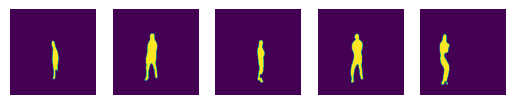

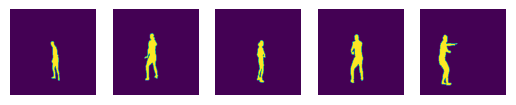

In [16]:
model.eval()
predictions = []
image_mask = []
plots = 5
images, masks = test_dataset[0], test_dataset[1]
for i, (img, mask) in enumerate(zip(images, masks)):
    if i == plots:
        break
    img = img.to(device).unsqueeze(0)
    predictions.append((model(img).detach().cpu()[0] > 0.5).float())
    image_mask.append(mask)
plotn(plots, (predictions, image_mask), only_mask=True)

### UNet

In [17]:
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.BCEWithLogitsLoss()
train(dataloaders, model, loss_fn, optimizer, epochs, device)

100%|██████████████████████████████████████████████| 30/30 [03:24<00:00,  6.82s/it, train loss:=0.681, test loss:=0.682]


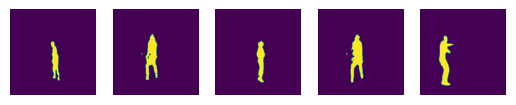

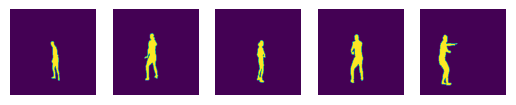

In [18]:
model.eval()
predictions = []
image_mask = []
plots = 5
images, masks = test_dataset[0], test_dataset[1]
for i, (img, mask) in enumerate(zip(images, masks)):
    if i == plots:
        break
    img = img.to(device).unsqueeze(0)
    predictions.append((model(img).detach().cpu()[0] > 0.5).float())
    image_mask.append(mask)
plotn(plots, (predictions, image_mask), only_mask=True)

## KalebNet

In [19]:
model = KalebNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.BCEWithLogitsLoss()
train(dataloaders, model, loss_fn, optimizer, epochs, device)

100%|██████████████████████████████████████████████| 30/30 [02:36<00:00,  5.22s/it, train loss:=0.683, test loss:=0.684]


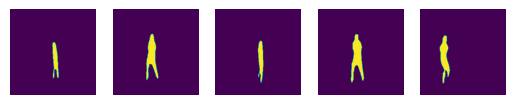

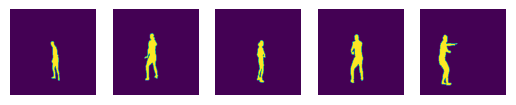

In [20]:
model.eval()
predictions = []
image_mask = []
plots = 5
images, masks = test_dataset[0], test_dataset[1]
for i, (img, mask) in enumerate(zip(images, masks)):
    if i == plots:
        break
    img = img.to(device).unsqueeze(0)
    predictions.append((model(img).detach().cpu()[0] > 0.5).float())
    image_mask.append(mask)
plotn(plots, (predictions, image_mask), only_mask=True)